In [1]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
from lib.d3pm import make_diffusion
import os
from lib.datasets.maze import maze_acc
from ruamel.yaml.scalarfloat import ScalarFloat

In [2]:
# creating path


path = "SavedModels/MAZE/"
date = '2024-02-06' # 2
config_name = 'config_001_d3pm_1000.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_d3pm.pt'

path = "SavedModels/Synthetic/"
date = '2024-02-09' # 2
config_name = 'config_001_d3pm_lin.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_d3pm_lin.pt'

path = "SavedModels/MAZE/"
date = '2024-02-07' # 2
config_name = 'config_001_d3pm.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_d3pm2.pt'

path = "SavedModels/MAZE/"
date = '2024-02-23' # 2
config_name = 'config_001_d3pmnll.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_d3pmnll.pt'

path = "SavedModels/MNIST/"
date = '2024-02-07' # 2
config_name = 'config_001_d3pm.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_599999_d3pm.pt'

config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)



In [3]:
# creating models
cfg = bookkeeping.load_config(config_path)

diffusion = make_diffusion(cfg.model)
#print(cfg)
device = torch.device(cfg.device)
print(device)

model = model_utils.create_model(cfg, device)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path, device)
state['model'].eval()

# Maze:
# 80% TauL
# 84% LBJF
# 96%

2024-03-02 16:34:21.491 | INFO     | lib.d3pm:__init__:100 - [compute transition matrix]: gaussian


in betas 1000
from beta 1000


2024-03-02 16:34:33.667 | INFO     | lib.d3pm:__init__:121 - [trainsition matrix]: torch.Size([1000, 256, 256])
2024-03-02 16:34:33.669 | INFO     | lib.d3pm:__init__:124 - [Construct transition matrices for q(x_t|x_start)]
2024-03-02 16:34:35.224 | INFO     | lib.d3pm:__init__:144 - [tilde(Q)t]: torch.Size([1000, 256, 256])


cuda
number of parameters:  14017696
ema state dict function


In [4]:
n_samples = 100
if cfg.data.name == 'Maze3S':
    shape = (n_samples, 1, 15, 15)
elif cfg.data.name == 'DiscreteMNIST':
    shape = (n_samples, 1, 28, 28)
elif cfg.data.name == 'SyntheticData':
    shape = (n_samples, 32)
else:
    raise ValueError("wrong")

samples = diffusion.p_sample_loop(state['model'], shape, cfg.model.num_timesteps).cpu().numpy()
saved_samples = samples
# 11:38 D3PM
# 12 ELBO


2024-03-02 16:34:37.847 | INFO     | lib.d3pm:p_sample_loop:553 - cuda
1000it [03:03,  5.46it/s]


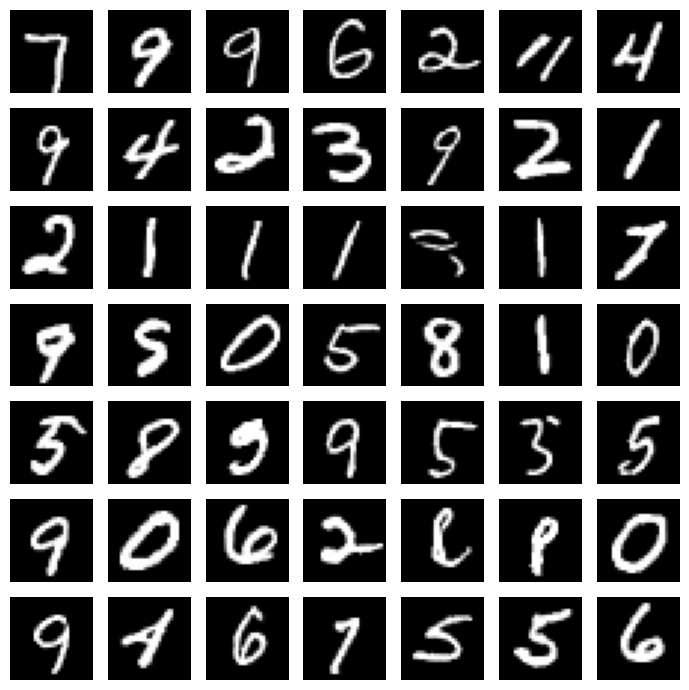

In [6]:
np.save(f'mnist_d3pm_elbo.npy', samples)
n_samples = 7 * 7
s_name = f'mnist_d3pm_elbo.npy'
#s_name = 'Samples/MNIST/mnist_hollow_crmnll_TauL1000.npy' # Samples/MNIST/
samples = np.load(s_name)
#samples = samples[550:]
samples = samples.reshape(-1, 1, 28, 28)
#saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
fig = plt.figure(figsize=(7, 7)) 
plt.subplots_adjust(wspace=0.00, hspace=0.00)
int(np.sqrt(n_samples))
for i in range(n_samples):
    plt.subplot(int(7), int(7), 1 + i)
    plt.axis("off")
    plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")

plt.tight_layout()  
plt.savefig('mnist_d3pm_elbo.pdf', transparent=True)
plt.show()
plt.close()

In [ ]:
from lib.datasets.mnist_fid import evaluate_fid_score
data = np.load(f'Samples/MNIST/mnist_unet_d3pm_1000.npy')
dataset_location = "lib/datasets"
fid_values = []
#data = np.load('mpl_x.npy')
print(data.shape)
cfg.data.train = False
dataset = dataset_utils.get_dataset(cfg, device, dataset_location)

dataloader = torch.utils.data.DataLoader(dataset,
    batch_size=data.shape[0],
    shuffle=cfg.data.shuffle)
for true_data in (dataloader):
    #print(f'mnist_hollow_{sampler_n}{step}.npy')
    print("----------------------------------")

    fid = evaluate_fid_score(data, true_data.cpu().numpy(), 100)
    print("FID:", fid)
    fid_values.append(fid)
    break
print(fid_values)
# d3pm fid values = 1,78
# is # Inception mean:  8.65325409905818
# Inception std:  0.07323019223425542

In [ ]:
#state['n_iter'] = 299999
#bookkeeping.save_state(state, "SavedModels/MAZE")

In [ ]:
is_img = False
#n_samples = 9
if is_img:
    samples = samples.reshape(-1, 1, cfg.data.image_size, cfg.data.image_size)
    saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    fig = plt.figure(figsize=(9, 9)) 
    for i in range(n_samples):
        plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
        plt.axis("off")
        plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")
 
    # saving_train_path
    plt.savefig('crm_hollow.pdf', transparent=True)
    plt.show()
    plt.close()
else:
    bm, inv_bm = synthetic.get_binmap(cfg.model.concat_dim, cfg.data.binmode)
    print(inv_bm)
    samples = synthetic.bin2float(samples.astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)

 
    saving_plot_path = os.path.join(path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    saving_np_path = os.path.join(path, f"samples_{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.npy")
    #np.save(f'{saving_np_path}', samples)

    #aving_plot_path = '/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/TAUnSDDM/SavedModels/MNIST/'
    synthetic.plot_samples(samples, 'd3pm_synthetic3.pdf', im_size=cfg.data.plot_size, im_fmt="pdf")

In [ ]:
#saved_samples = np.load('mazes3000_auxprotein1_lbjf.npy')
correct_mazes = maze_acc(saved_samples)

In [ ]:
cfg.data.name = 'Maze3SComplete'
cfg.data.batch_size = n_samples

if cfg.data.name == 'Maze3SComplete':
    limit = cfg.data.batch_size
    cfg.data.limit = limit 

dataset = dataset_utils.get_dataset(cfg, device)
dataloader = torch.utils.data.DataLoader(dataset,
    batch_size=cfg.data.batch_size,
    shuffle=cfg.data.shuffle)

for i in dataloader:
    true_dl = i
    c_i = maze_acc(i.cpu().numpy())
    true_dl = true_dl.reshape(cfg.data.batch_size, -1) #.flatten()

In [ ]:
from scipy.stats import wasserstein_distance
#samples = np.load('mazes2000_hollow_aux_lbjf.npy')
#samples = np.load('Samples/Maze/mazes_hollow_CRMTauL1000.npy')
saved_samples = samples
samples = samples.reshape(-1,225) #.flatten()
samples = samples[:n_samples]


emd_dist = []
correct_mazes = maze_acc(saved_samples)
for i in range(samples.shape[0]):
    m_g = samples[i, :]
    emd = wasserstein_distance(samples[i, :], true_dl[i, :].cpu().numpy())
    emd_dist.append(emd)
    #print(i, emd_dist)
#print("EMD", wasserstein_distance(samples, true_dl.cpu().numpy()))
#print("EMD", emd_dist)
print("AVG", np.mean(emd_dist))